# MGMT radiomics baseline pipeline (dummy → RF → GA-RF)

This notebook shows how to:
- load the four pre-split CSV files you created,
- get floor performance using dummy classifiers,
- train a plain Random Forest on all radiomics features,
- plug in a GA-selected feature subset to train GA-RF.

All comments in the code are in English so you can paste this into GitHub or a report.


In [74]:
import os
import random
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

## 1. Load data
We load `X_train_xgbsel.csv`, `X_test_xgbsel.csv`, `y_train.csv`, and `y_test.csv`.  
Labels are squeezed to 1D so that scikit-learn can use them directly.  
If your labels are strings like `"Methylated"`, you can map them to integers right after loading.


In [58]:
# set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# read feature matrices
X_train = pd.read_csv("../data/X_train_xgbsel.csv")   # training features
X_test  = pd.read_csv("../data/X_test_xgbsel.csv")    # held-out test features

# read target vectors (squeeze → Series, not DataFrame)
y_train = pd.read_csv("../data/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/y_test.csv").squeeze()

# quick sanity check on shapes
print("X_train:", X_train.shape)   # (n_train, d)
print("X_test: ", X_test.shape)    # (n_test, d)
print("y_train:", y_train.shape)   # (n_train,)
print("y_test: ", y_test.shape)    # (n_test,)

# --- GA will select columns from TRAIN ---
New_FS = X_train.copy()               # GA works on training features
y_trn  = y_train.reset_index(drop=True)

print("GA base features (train):", New_FS.shape)
print("GA base labels  (train):", y_trn.shape)

GA_POP_PATH   = "../data/ga_pop.npy"
GA_SCORE_PATH = "../data/ga_scores.npy"

size  = 50
n_feat = New_FS.shape[1]   # number of features GA will see

# 1) Convert pandas DataFrames to NumPy arrays in advance
X_np = New_FS.to_numpy(dtype=np.float32)
y_np = y_trn.to_numpy()

# 2) Precompute the folds from StratifiedKFold (we’ll reuse these in fitness)
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = [(train_idx, test_idx) for train_idx, test_idx in kfold.split(X_np, y_np)]


# if labels are text, map to 0/1 here
# y_trn = (y_trn == "Methylated").astype(int)
# y_test = (y_test == "Methylated").astype(int)


X_train: (53, 38)
X_test:  (65, 38)
y_train: (53,)
y_test:  (65,)
GA base features (train): (53, 38)
GA base labels  (train): (53,)


## 2. Dummy baselines
We train two dummy models to see the minimum performance on this split.  
`most_frequent` = always predict the majority class.  
`stratified` = predict classes according to training distribution (a bit harder baseline).


In [59]:
# dummy that always predicts the most frequent class in y_train
dummy_mf = DummyClassifier(strategy="most_frequent")
dummy_mf.fit(X_train, y_train)
y_pred_mf = dummy_mf.predict(X_test)
acc_mf = accuracy_score(y_test, y_pred_mf)
print(f"Dummy (most_frequent) accuracy on TEST: {acc_mf:.3f}")

# dummy that samples labels according to class proportion in y_train
dummy_st = DummyClassifier(strategy="stratified", random_state=42)
dummy_st.fit(X_train, y_train)
y_pred_st = dummy_st.predict(X_test)
acc_st = accuracy_score(y_test, y_pred_st)
print(f"Dummy (stratified) accuracy on TEST:   {acc_st:.3f}")

Dummy (most_frequent) accuracy on TEST: 0.200
Dummy (stratified) accuracy on TEST:   0.462


## 3. Plain Random Forest (no GA)

We now train a real model on **all 725 radiomics features** using only the 42 training cases.  
Because the training set is small and high-dimensional, we first run a 5-fold **stratified** cross-validation on the training set to get a more stable estimate.  



In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample",
)

# internal CV on the TRAIN set
cv_acc = cross_val_score(rf, X_train, y_train, cv=cv, scoring="accuracy")
print("RF 5-fold CV accuracy:", cv_acc)
print("RF 5-fold CV accuracy (mean):", cv_acc.mean())

if y_train.nunique() == 2:
    cv_auc = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc")
    print("RF 5-fold CV AUC:", cv_auc)
    print("RF 5-fold CV AUC (mean):", cv_auc.mean())

# fit on all training samples
rf.fit(X_train, y_train)

# evaluate once on the held-out TEST set
y_pred_test = rf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print("\nRF TEST accuracy:", round(acc_test, 3))

if y_test.nunique() == 2:
    y_proba_test = rf.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_proba_test)
    print("RF TEST AUC:     ", round(auc_test, 3))

print("\nRF TEST classification report:")
print(classification_report(y_test, y_pred_test))

RF 5-fold CV accuracy: [0.90909091 0.72727273 1.         0.9        0.8       ]
RF 5-fold CV accuracy (mean): 0.8672727272727272
RF 5-fold CV AUC: [0.95 0.9  1.   0.88 0.76]
RF 5-fold CV AUC (mean): 0.898

RF TEST accuracy: 0.662
RF TEST AUC:      0.669

RF TEST classification report:
              precision    recall  f1-score   support

           0       0.24      0.31      0.27        13
           1       0.81      0.75      0.78        52

    accuracy                           0.66        65
   macro avg       0.52      0.53      0.52        65
weighted avg       0.70      0.66      0.68        65



## 4. GA-RF (paper-faithful version)

Below is a version that matches the 2022 code style much more closely.

Key points:

- we recreate their globals: `New_FS`, `y_trn`, `kfold`, `model`
- we keep their function names: `initilization_of_population`, `fitness_score`, `selection`, `crossover`, `mutation`, `generations`
- we fix only the things that would break in pandas/NumPy now:
  - `np.bool` → `bool`
  - `.iloc[train].iloc[:,chromosome]` → `.iloc[train, chromosome]`
- at the end we **actually call** `generations(...)` so you see `gen 0 ...`, `gen 1 ...` printed like their script
- this version uses **your** data: `X_train` → `New_FS`, `y_train` → `y_trn`

You can change `n_gen` or `size` later. After this, in step 5, you can take `best_chromo[-1]` and train a clean RF/XGB on that subset.


In [61]:
# ================================
# 1. set up data and base model
# ================================

# GA will search over training features
New_FS = X_train.copy()

# labels for GA
y_trn = y_train.reset_index(drop=True)

# NOTE:
# we will create StratifiedKFold INSIDE the GA outer loop
# e.g. kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)
# so we don't fix it here

model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample",
)

# GA/global hyperparameters
size = 50
n_feat = New_FS.shape[1]


In [62]:
# ================================
# 2. population init + fitness
# ================================
def initilization_of_population(size, n_feat, off_ratio=0.3, rng=None):
    """
    create an initial list of chromosomes
    each chromosome is a boolean mask over features
    about `off_ratio` will be OFF (False), the rest ON (True), then shuffled
    """
    if rng is None:
        rng = np.random.default_rng(42)
    population = []
    off_cnt = int(off_ratio * n_feat)
    for _ in range(size):
        chromosome = np.ones(n_feat, dtype=bool)
        chromosome[:off_cnt] = False
        rng.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population, kfold=None, model=None, X=None, y=None):
    """
    evaluate each chromosome by k-fold CV accuracy (now using precomputed numpy folds)

    population: list of boolean masks
    kfold: kept for backward-compatibility (not used if global `folds` exists)
    model: sklearn classifier INSTANCE or FACTORY
           - if it's an instance, we'll clone-like recreate per fold
           - if it's a callable, we'll call it to get a fresh model
    X, y: ignored if global X_np / y_np / folds are defined
    """
    # 1) use global numpy data (fast path)
    global X_np, y_np, folds

    scores, newtp, newfp, newtn, newfn = [], [], [], [], []

    for chromosome in population:
        # boolean mask -> column indices
        col_idx = np.where(chromosome)[0]

        # empty subset guard
        if col_idx.size == 0:
            scores.append(0.0)
            newtp.append(0); newfp.append(0); newtn.append(0); newfn.append(0)
            continue

        tp_list, fp_list, tn_list, fn_list, acc_list = [], [], [], [], []

        # 2) use precomputed folds
        for train_idx, test_idx in folds:
            X_tr = X_np[train_idx][:, col_idx]
            X_te = X_np[test_idx][:, col_idx]
            y_tr = y_np[train_idx]
            y_te = y_np[test_idx]

            # make a fresh model every fold
            if callable(model):
                clf = model()
            else:
                # assume it's already an instance we can reuse safely
                # (most of the time better to pass a factory)
                clf = model

            clf.fit(X_tr, y_tr)
            preds = clf.predict(X_te)

            # confusion matrix (2-class, force labels)
            tn_i, fp_i, fn_i, tp_i = confusion_matrix(
                y_te, preds, labels=[0, 1]
            ).ravel()

            tp_list.append(tp_i); fp_list.append(fp_i)
            tn_list.append(tn_i); fn_list.append(fn_i)

            acc_list.append(accuracy_score(y_te, preds))

        # aggregate over folds
        scores.append(float(np.mean(acc_list)))
        newtp.append(int(np.sum(tp_list)))
        newfp.append(int(np.sum(fp_list)))
        newtn.append(int(np.sum(tn_list)))
        newfn.append(int(np.sum(fn_list)))

    # 3) sort by score desc
    scores = np.array(scores, dtype=float)
    population = np.array(population, dtype=object)

    total_score = scores.sum()
    if total_score == 0:
        weights = np.ones_like(scores) / len(scores)
    else:
        weights = scores / total_score

    newtp = np.array(newtp); newfp = np.array(newfp)
    newtn = np.array(newtn); newfn = np.array(newfn)

    inds = np.argsort(scores)[::-1]

    return (
        list(scores[inds]),
        list(population[inds]),
        list(weights[inds]),
        list(newtp[inds]),
        list(newfp[inds]),
        list(newtn[inds]),
        list(newfn[inds]),
    )


In [63]:
# ================================
# 3. GA operators (selection / crossover / mutation)
# ================================
def selection(pop_after_fit, weights, k):
    """
    Sample k chromosomes from the current population using
    fitness-based weights (roulette-wheel style).
    """
    picked = random.choices(pop_after_fit, weights=weights, k=k)
    return list(picked)


def crossover(p1, p2, crossover_rate):
    """
    Single-point crossover.
    Two parents → two children.
    With probability <crossover_rate> we swap tails after a random point.
    Otherwise we just copy the parents.
    """
    c1, c2 = p1.copy(), p2.copy()

    # need at least 3 genes to do a meaningful 1-point crossover
    if random.random() < crossover_rate and len(p1) > 2:
        pt = random.randint(1, len(p1) - 2)
        c1 = np.concatenate((p1[:pt], p2[pt:]))
        c2 = np.concatenate((p2[:pt], p1[pt:]))

    return [c1, c2]


def mutation(chromosome, mutation_rate):
    """
    Flip each bit with probability = mutation_rate.
    Return a NEW chromosome (don’t mutate callers' copy by surprise).
    """
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] = not mutated[i]
    return mutated


In [64]:
# ================================
# 4. full GA loop (original style)
# ================================
def generations(size, n_feat, crossover_rate, mutation_rate, n_gen):
    """
    run GA for n_gen generations in one shot
    (this is the original style)
    """
    best_chromo = []
    best_score = []

    # start with random population
    population_nextgen = initilization_of_population(size, n_feat)

    for gen in range(n_gen):
        # evaluate population
        scores, pop_after_fit, weights, tp, fp, tn, fn = fitness_score(population_nextgen)

        # best of this generation
        top_score = scores[0]
        top_chrom = pop_after_fit[0]
        print("gen", gen, "best_acc=", round(top_score, 4), "on_features=", int(top_chrom.sum()))

        # elitism (keep 2)
        elites = pop_after_fit[:2]
        k = size - 2

        # select parents
        parents = selection(pop_after_fit, weights, k)

        # make children
        children = []
        for i in range(0, len(parents), 2):
            p1 = parents[i]
            p2 = parents[(i + 1) % len(parents)]
            for child in crossover(p1, p2, crossover_rate):
                mutation(child, mutation_rate)
                children.append(child)

        # build next population
        population_nextgen = []
        for c in elites:
            population_nextgen.append(c)
        for c in children:
            if len(population_nextgen) < size:
                population_nextgen.append(c)

        # keep history
        best_chromo.append(top_chrom)
        best_score.append(top_score)

    return best_chromo, best_score


In [65]:
# ================================
# 5. single GA step (one generation)
# ================================
def ga_one_step(
    population,
    size,
    crossover_rate,
    mutation_rate,
    model,
):
    """
    Run GA for exactly 1 generation and return:
      - next_population
      - best_chromo (from current generation)
      - best_score  (from current generation)
    Uses global X_np, y_np, folds via fitness_score().
    """
    # 1) evaluate current population
    scores, pop_after_fit, weights, tp, fp, tn, fn = fitness_score(
        population,
        model=model,
        # kfold, X, y not needed anymore
    )

    # 2) best in this generation
    best_score  = scores[0]
    best_chromo = pop_after_fit[0]

    # 3) keep top-2 (elitism)
    elites = pop_after_fit[:2]
    k = size - 2

    # 4) select parents for the remaining slots
    parents = selection(pop_after_fit, weights, k)

    # 5) crossover + mutation → build children
    children = []
    for i in range(0, len(parents), 2):
        p1 = parents[i]
        p2 = parents[(i + 1) % len(parents)]  # wrap around
        for child in crossover(p1, p2, crossover_rate):
            # your mutation() mutates in-place and returns None in original code
            mutation(child, mutation_rate)
            children.append(child)

    # 6) build next population (elites first)
    next_pop = []
    # add elites
    for e in elites:
        next_pop.append(e)
    # add children until we reach "size"
    for c in children:
        if len(next_pop) < size:
            next_pop.append(c)

    return next_pop, best_chromo, best_score


# GA BEST NPZ

In [66]:
BEST_PATH = "../data/ga_best.npz"
TOP_K = 5

def update_top_solutions_by_run(best_path, run_id, new_score, new_mask, new_cols, top_k=5):
    """
    Keep at most `top_k` best runs (one entry per run_id).
    If file exists but has old / wrong keys, we re-initialize.
    """
    prev_run_ids, prev_scores, prev_masks, prev_cols = [], [], [], []

    if os.path.exists(best_path):
        try:
            prev = np.load(best_path, allow_pickle=True)
            # try to read modern keys
            prev_run_ids = prev["run_ids"].tolist()
            prev_scores  = prev["top_scores"].tolist()
            prev_masks   = prev["top_masks"].tolist()
            prev_cols    = prev["top_cols"].tolist()
        except KeyError:
            # old / incompatible file → start fresh
            prev_run_ids, prev_scores, prev_masks, prev_cols = [], [], [], []

    # update or append
    if run_id in prev_run_ids:
        idx = prev_run_ids.index(run_id)
        if new_score > prev_scores[idx]:
            prev_scores[idx] = float(new_score)
            prev_masks[idx]  = new_mask
            prev_cols[idx]   = new_cols
    else:
        prev_run_ids.append(run_id)
        prev_scores.append(float(new_score))
        prev_masks.append(new_mask)
        prev_cols.append(new_cols)

    # keep top_k
    order = np.argsort(prev_scores)[::-1][:top_k]

    top_run_ids = [prev_run_ids[i] for i in order]
    top_scores  = [prev_scores[i]  for i in order]
    top_masks   = [prev_masks[i]   for i in order]
    top_cols    = [prev_cols[i]    for i in order]

    # save back
    np.savez(
        best_path,
        run_ids=np.array(top_run_ids, dtype=int),
        top_scores=np.array(top_scores, dtype=float),
        top_masks=np.array(top_masks, dtype=object),
        top_cols=np.array(top_cols, dtype=object),
    )
    return top_run_ids, top_scores

## Repeated GA with stratified 5-fold CV (20×) 

In [67]:
N_REPEATS = 3
GENS_PER_RUN = 15

for run in range(N_REPEATS):
    # 1) No need to create a new kfold here anymore
    # kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

    # 2) initialize population
    pop = initilization_of_population(size=size, n_feat=n_feat)
    history_chromo, history_score = [], []

    for gen in range(GENS_PER_RUN):
        pop, bc, bs = ga_one_step(
            pop,
            size=size,
            crossover_rate=0.8,
            mutation_rate=0.05,
            # kfold=kfold,      # no longer needed
            # X=New_FS,         # fitness now uses X_np
            # y=y_trn,          # fitness now uses y_np
            model=model,        # keep this (preferably pass a factory)
        )
        history_chromo.append(bc)
        history_score.append(bs)

    # pick the best solution inside THIS run
    best_idx   = int(np.argmax(history_score))
    best_score = float(history_score[best_idx])
    best_mask  = history_chromo[best_idx]
    best_cols  = np.where(best_mask)[0]

    run_ids, top_scores = update_top_solutions_by_run(
        BEST_PATH,
        run_id=run,
        new_score=best_score,
        new_mask=best_mask,
        new_cols=best_cols,
        top_k=5,
    )

    print("top runs:", run_ids)
    print("top scores:", top_scores)


top runs: [0, 1, 2]
top scores: [0.8872727272727273, 0.6636363636363637, 0.6636363636363637]
top runs: [1, 0, 2]
top scores: [0.9054545454545455, 0.8872727272727273, 0.6636363636363637]
top runs: [2, 1, 0]
top scores: [0.9072727272727272, 0.9054545454545455, 0.8872727272727273]


# Show the result 

In [68]:
best = np.load("../data/ga_best.npz", allow_pickle=True)
run_ids    = best["run_ids"].tolist()
top_scores = best["top_scores"].tolist()
top_cols   = best["top_cols"].tolist()

print("=== TOP RUNS ===")
for rid, s, cols in zip(run_ids, top_scores, top_cols):
    print(f"run {rid}: score={s:.4f}, cols(first 5)={cols[:5]}, total={len(cols)}")


=== TOP RUNS ===
run 2: score=0.9073, cols(first 5)=[1 2 4 5 6], total=26
run 1: score=0.9055, cols(first 5)=[0 1 2 3 5], total=31
run 0: score=0.8873, cols(first 5)=[0 1 2 3 5], total=26


In [71]:
# GA-RF final eval (minimal: GA score + test AUC)

# 1) load GA results
best = np.load("../data/ga_best.npz", allow_pickle=True)
top_scores = best["top_scores"].tolist()
top_masks  = best["top_masks"].tolist()

# 2) pick best GA subset
best_mask = top_masks[0]
best_cols = np.where(best_mask)[0]

print("GA (saved) best CV acc:", top_scores[0])

# 3) slice to GA-selected features
X_train_sel = X_train.iloc[:, best_cols].copy()
X_test_sel  = X_test.iloc[:, best_cols].copy()

# 4) RF on GA-selected features (small grid)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10],
    "max_features": ["sqrt"],
    "class_weight": ["balanced_subsample"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=0,
)
grid.fit(X_train_sel, y_train)

# 5) test AUC only
best_rf = grid.best_estimator_
y_proba_test = best_rf.predict_proba(X_test_sel)[:, 1]
test_auc = roc_auc_score(y_test, y_proba_test)
print("RF (GA-selected) TEST AUC:", round(test_auc, 3))


GA (saved) best CV acc: 0.9072727272727272
RF (GA-selected) TEST AUC: 0.624


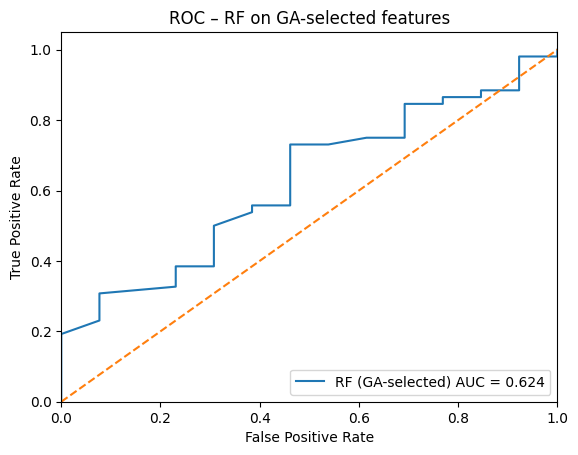

In [76]:

# only draw ROC when it's truly binary (0/1)
if y_test.nunique() == 2:
    # 1) turn test labels + predicted probs into ROC curve points
    #    fpr: x-axis (1 - specificity)
    #    tpr: y-axis (sensitivity/recall)
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    # 2) compute the area under that curve
    roc_auc = auc(fpr, tpr)

    # 3) start a new figure
    plt.figure()

    # 4) draw our model's ROC
    plt.plot(fpr, tpr, label=f"RF (GA-selected) AUC = {roc_auc:.3f}")

    # 5) draw the random-classifier line (AUC=0.5)
    plt.plot([0, 1], [0, 1], linestyle="--")

    # 6) make axes nice
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # 7) labels + title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC – RF on GA-selected features")

    # 8) show legend with AUC
    plt.legend(loc="lower right")

    # 9) actually render the plot
    plt.show()